In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.datasets import mnist

In [5]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0


In [6]:
X_train = X_train.reshape((X_train.shape[0], -1))
X_test = X_test.reshape((X_test.shape[0], -1))


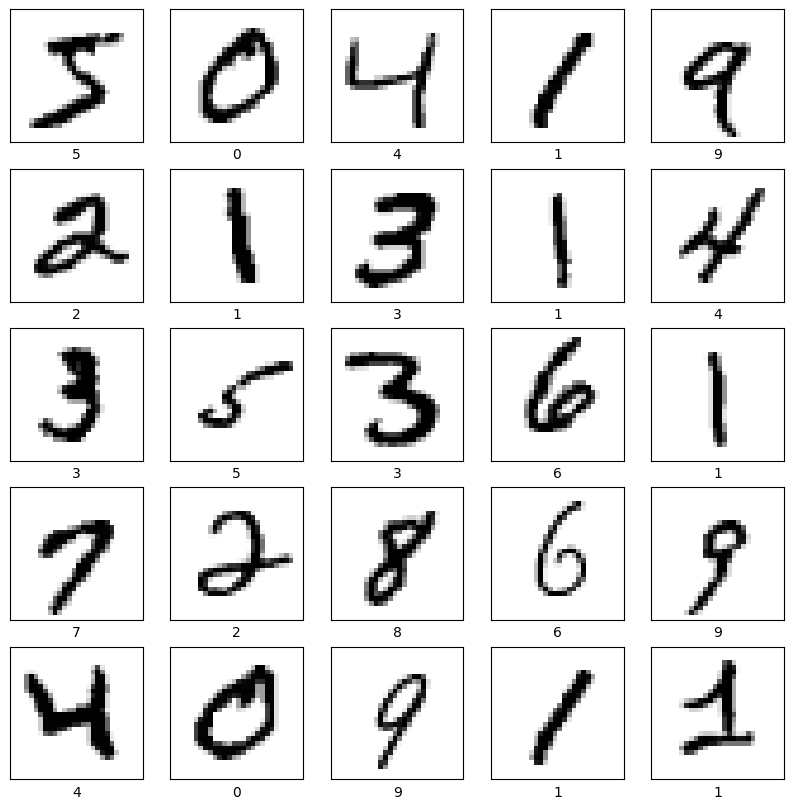

In [7]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [8]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        self.W1 = np.random.randn(self.input_size, self.hidden_size)
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size)
        self.b2 = np.zeros((1, self.output_size))


    def forward(self, X):
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = np.maximum(0, self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        # Subtracting the maximum value
        exp_scores = np.exp(self.z2 - np.max(self.z2, axis=1, keepdims=True))
        self.probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return self.probs


    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        delta3 = self.probs
        delta3[range(m), y] -= 1
        delta3 /= m

        dW2 = np.dot(self.a1.T, delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)

        delta2 = np.dot(delta3, self.W2.T)
        delta2[self.a1 <= 0] = 0

        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2

    def train(self, X, y, learning_rate, epochs):
        for epoch in range(epochs):
            self.forward(X)
            self.backward(X, y, learning_rate)

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42)

In [10]:
input_size = 784
hidden_size = input_size * 2
output_size = 10
learning_rate = 0.7
epochs = 100

model = NeuralNetwork(input_size, hidden_size, output_size)

model.train(X_train, y_train, learning_rate, epochs)

train_predictions = model.predict(X_train)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

train_accuracy = accuracy_score(y_train, train_predictions)
val_accuracy = accuracy_score(y_val, val_predictions)
test_accuracy = accuracy_score(y_test, test_predictions)

print("Train Accuracy:", train_accuracy)
print("Validation Accuracy:", val_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.8963541666666667
Validation Accuracy: 0.8735
Test Accuracy: 0.8825


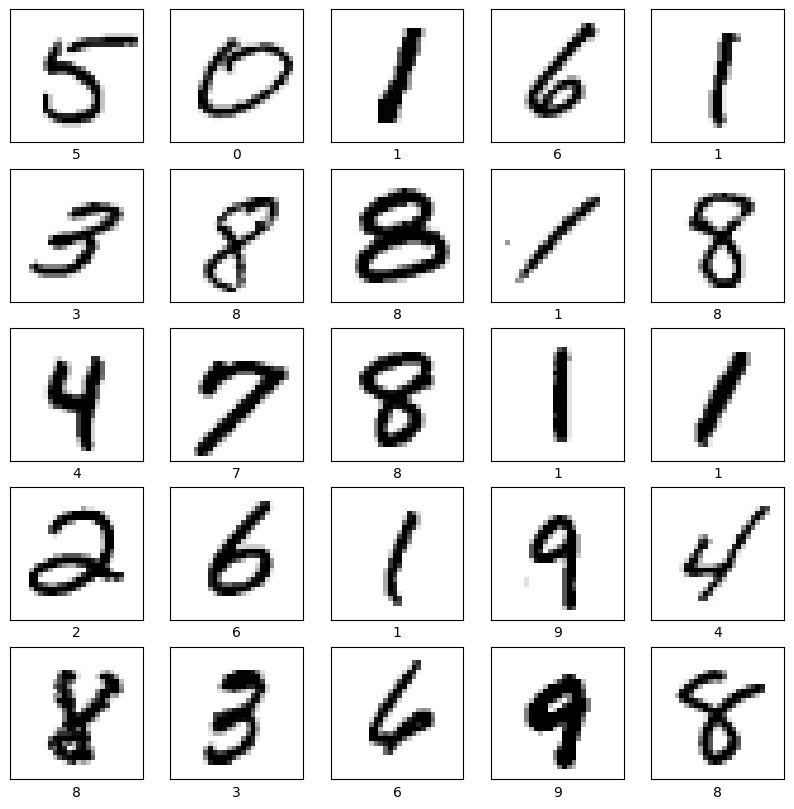

In [11]:

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()